In [1]:
import sys                       
sys.path.append('.')
from robot_aoa import *
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise
from math import sin, cos, tan, atan2, sqrt
import traceback

In [2]:
class EstimationAgent(Agent): 
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    # observasion: data from the sensors
    # self.{nu,omega}: movement
    def decision(self, observation=None): 
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.estimator.observation_update(observation)
        return self.nu, self.omega
        
    def draw(self, ax, elems): ###mlwrite
        self.estimator.draw(ax, elems)
        #x, y, t = self.estimator.pose #以下追加
        #s = "({:.2f}, {:.2f}, {})".format(x,y,int(t*180/math.pi)%360)
        #elems.append(ax.text(x, y+0.1, s, fontsize=8))

In [3]:
def move(x, dt, u):
    return IdealRobot.state_transition(u[0], u[1], dt, x)

def normalize_angle(x):
    x = x % (2 * np.pi)    # x を [0, 2 pi) の範囲に変換する。
    if x > np.pi:          # x を [-pi, pi) に移す。
        x -= 2 * np.pi
    return x

def residual_h(a, b):
    y = a - b
    return [normalize_angle(_y) for _y in y]

def residual_x(a, b):
    y = a - b
    y[2] = normalize_angle(y[2])
    return y

# 状態変数を観測値に変換
def Hx(x, antennas):
    hx = []
    for atn in antennas:
        ax, ay = atn.pos
        angle = atan2(x[1] - ay, x[0] - ax)
        hx.extend([angle])
        
    return np.array(hx)

def state_mean(sigmas, Wm):
    x = np.zeros(3)
    sum_sin = np.sum(np.dot(np.sin(sigmas[:, 2]), Wm))
    sum_cos = np.sum(np.dot(np.cos(sigmas[:, 2]), Wm))
    x[0] = np.sum(np.dot(sigmas[:, 0], Wm))
    x[1] = np.sum(np.dot(sigmas[:, 1], Wm))
    x[2] = atan2(sum_sin, sum_cos)
    return x

def z_mean(sigmas, Wm):
    z_count = sigmas.shape[1]
    x = np.zeros(z_count)
    for z in range(len(x)):
        sum_sin = np.sum(np.dot(np.sin(sigmas[:, z]), Wm))
        sum_cos = np.sum(np.dot(np.cos(sigmas[:, z]), Wm))
        x[z] = atan2(sum_sin, sum_cos)

    return x

In [4]:
# Estimator
class EstimatorUKF:
    def __init__(self, envmap, dt, init_pose, sigma_bearing=0.1):
        points = MerweScaledSigmaPoints(n=3, alpha=.00001, beta=2, kappa=0,
                                    subtract=residual_x)
        ukf = UKF(dim_x=3, dim_z=1*len(envmap.antennas), fx=move, hx=Hx,
                  dt=dt, points=points, x_mean_fn=state_mean,
                  z_mean_fn=z_mean, residual_x=residual_x,
                  residual_z=residual_h)

        #ukf.x = np.array([2, 6, .3])
        ukf.x = init_pose
        ukf.P = np.diag([.1, .1, .05])
        ukf.R = np.diag([sigma_bearing**2]*len(envmap.antennas))
        ukf.Q = np.eye(3)*0.0001
        
        self.pose = ukf.x
        self.ukf = ukf  
        self.estimated_poses = [ukf.x]
        self.antennas = envmap.antennas
        
    def motion_update(self, nu, omega, time): #追加
        #値が0になるとゼロ割りになって計算ができないのでわずかに値を持たせる
        if abs(omega) < 1e-5: 
            omega = 1e-5

        self.ukf.predict(u=[nu, omega])
        self.pose = self.ukf.x
        
    #
    # Agent から呼ばれる
    # observasion はノイズを含むセンサからの観測値
    #    (z, ant.pos, ant.id) = robot.AoA.data()
    #         # 以下の理想的な値にノイズを載せたものが上記観測値となる
    #         z = IdealAoA.observation_function()
    #         # 観測値zの内訳は以下の通りで、0 は位置情報でありセンサデータとして未使用
    #         np.array([0, theta]).T
    #
    def observation_update(self, observation):  #追加
        # observation[]: [(0, 角度), アンテナ位置, 観測ID]
        #    z = d[0][1] # d[0] = (0, 角度)
        #    ant_pos = d[1]
        #    obs_id = d[2]
        ant1 =observation[0] 
        ant2 =observation[1] 
        z1 = ant1[0][1]
        z2 = ant2[0][1]
        
        self.ukf.update([z1, z2], antennas=self.antennas)
        
    def draw(self, ax, elems):
        x = self.ukf.x
        #elems.append(ax.text(0.5, 9.0, "x:" + str(x[0]), fontsize=10))
        #elems.append(ax.text(0.5, 8.5, "y:" + str(x[1]), fontsize=10))
        #elems += ax.plot(x[0], x[2], color="blue", alpha=0.5, linewidth=0.5, marker='o')
        
        self.estimated_poses.append(x)
        xs = [_x[0] for _x in self.estimated_poses]
        ys = [_x[1] for _x in self.estimated_poses]
        elems += ax.plot(xs, ys, color="blue", alpha=0.5, linewidth=0.5)
        c = patches.Circle(xy=(x[0], x[1]), radius=0.1, fill=True, alpha=0.5, color="blue")
        elems.append(ax.add_patch(c))

<IPython.core.display.Javascript object>


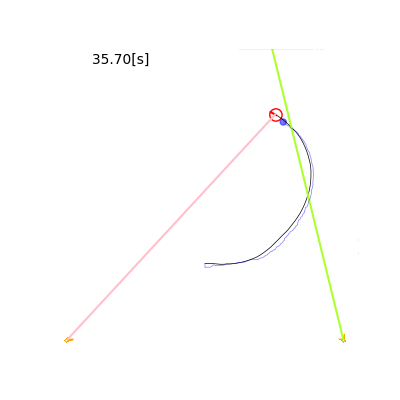

In [5]:
if __name__ == '__main__': 
    dt = 0.1
    #world = World(60, dt, debug=True)  
    world = World(60, dt)
    
    m = Map()                                  
    m.append_antenna(Antenna(0.5, 0.5))
    m.append_antenna(Antenna(9.5, 0.5))
    world.append(m)        
    
    #pose, nu, omega = np.array([2, 4, 0]), 0.2, 0.0
    pose, nu, omega = np.array([5, 3, 0]), 0.2, 5.0/180*math.pi
    
    e = EstimatorUKF(m, dt, pose)
    a = EstimationAgent(dt, nu, omega, e)
    r = Robot(pose, sensor=AoA(m), agent=a, color="red") 
    
    world.append(r)
                 
    ### アニメーション実行 ###
    world.draw()